<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Sistemas de Recomendación basado en Contenidos

Este *cuaderno* trata sobre filtrado colaborativo basado en contenidos. El objetivo del *cuaderno* es que usted obtenga una visión general del problema predictivo de los sistemas de recomendación que utilizan filtrado colaborativo basado en contenidos, aprenda distintos algoritmos que lo implementan, y que sea capaz de reconocer sus características, funcionamiento, y  desarrollarlos en `Python`.

**NO** es necesario editar el archivo o hacer una entrega. Sin embargo, los ejemplos contienen celdas con código ejecutable (`en gris`), que podrá modificar  libremente. Esta puede ser una buena forma de aprender nuevas funcionalidades del *cuaderno*, o experimentar variaciones en los códigos de ejemplo.

## Introducción

Los sistemas basados en contenido, a diferencia de los filtros colaborativos, no requieren datos relacionados a otros individuos u actividades pasadas. Por el contrario, estos brindan recomendaciones basadas en el perfil del usuario y los metadatos que se tiene sobre elementos particulares.

Si bien en este tipo de sistemas se utilizan la interacción entre un usuario y un ítem particular (lo compró, calificó, etc.) nosotros nos centraremos en el uso de texto asociado a los ítems. En este cuaderno en particular se abordará la construcción de dos tipos de recomendadores basados en contenido de películas, pero que pueden ser aplicados a otros productos:
 
 1. Recomendador basado en la descripción de la trama: este modelo compara las descripciones de diferentes películas y proporciona recomendaciones basado en películas con tramas similares.
 2. Recomendador basado en metadatos: este modelo tiene en cuenta una gran cantidad de características, como géneros, palabras clave, elenco, director, etc. A partir de ellos proporciona recomendaciones que son las más similares basadas en estas características.
 

## Texto como datos

Para poder utilizar el texto asociado a los ítems debemos primero transformarlo en datos que puedan ser utilizado por los sistemas de recomendación. La idea es que utilicemos estos datos de forma tal que podamos construir medidas de similitud entre ellos. Dicho de otra forma, si tenemos tres películas A, B y C; ¿Cómo medimos cuán similares son la trama de A con la de B o la de C?

El primer paso entonces es representar este texto como  vectores. En otras palabras, cada documento se representa como una serie de n números, donde cada número representa una dimensión y n es el tamaño del vocabulario de todos los documentos juntos. Donde los valores de los vectores van a depender del vectorizador que utilizamos. Los dos vectorizadores más populares son `CountVectorizer` y `TF-IDFVectorizer`.

### CountVectorizer

El `CountVectorizer` es la forma más sencilla de vectorizar el texto. Para explicarlo utilizaremos un ejemplo. Supongamos que tenemos los siguientes 3 documentos, A, B, y C:

  - A: El sol es una estrella.
  - B: Un buen viajante no tiene planes.
  - C: Juan tiene una mascota nueva
  
Transformemos estos documentos en su forma vectorial utilizando `CountVectorizer`. El primer paso es encontrar el vocabulario para este grupo de documentos. Esto consiste en encontrar el número de palabras únicas: el, sol, es, una, estrella, un, buen, viajante, no, tiene, planes, Juan, mascota, nueva. Es decir, tokenizamos el texto y contamos el número de ocurrencias, en este caso el vocabulario es de 14 palabras.
 
Es común, como vimos en el *cuaderno Expresiones Regulares*, eliminar las stopwords. Por lo que, si hacemos esto, el tamaño del vocabulario se reduce a:  buen, estrella, Juan, mascota, nueva, planes, sol, viajante. Es decir, el tamaño ahora es 8.
 
Esto implica que los documentos se van a representar como vectores con 8 dimensiones, donde cada dimensión representa el número  de veces que la palabra ocurre:
 
- A:(0, 1, 0, 0, 0, 0, 1, 0)
- B:(1, 0, 0, 0, 0, 1, 0, 1)
- C:(0, 0, 1, 1, 1, 0, 0, 0)

### TF-IDFVectorizer

Sin embargo, podemos pensar que no todas las palabras en un documento pesan lo mismo. Por ejemplo, un documento sobre vacas contendrá frecuentemente el termino vaca. Por lo tanto, probablemente la presencia de esta palabra no sea tan informativa como algún otra.

El TF-IDFVectorizer (term frequency-inverse document frequency) incorpora esta noción  entonces el $tf-idf_{ij}$ de una palabra $i$ en el documento $j$ esta dado por:

$$
tf-idf_{ij}=tf_{ij} \times \left( \log \left( \frac{1+N}{1+df_i} \right)+1\right)
$$

donde:

- $tf_{ij}$ es la frequencia palabra $i$ en el documento $j$
- $df_{ij}$ es el número de documentos que contienen la palabra $i$ 
- $N$ es el número de documentos

Los vectores $tf-idf_{ij}$ resultantes luego son normalizados por la norma euclideana. Al hacer esta transformación tendremos que el peso de una palabra será mayor si aparece con más frecuencia o si está presente en menos documentos.

## Recomendador basado en trama

Estamos ahora en condiciones de armar una función que recomiende películas y/o series basado en la descripción de la trama. Para ello utilizaremos datos de películas y series recientes que provienen del sitio www.filmaffinity.com:

In [1]:
# Cargamos las librerías a utilizar
import pandas as pd
import numpy as np

# Cargamos los datos 
pelis = pd.read_csv('data/pelis_recommend.csv', sep=',')

pelis.head()

,titulo,ano,duracion,pais,direccion,guion,musica,fotografia,reparto,productora,genero,sinopsis,criticas,premios
0,Chapelwaite,2021,48 min.,Estados Unidos,"Stephen King (Creador), Rachel Leiterman, Mich...",Stephen King. Historia: Stephen King,Mark Korven,"David Greene, Miroslaw Baszak","Adrien Brody, Jennifer Ens, Sirena Gulamgaus, ...",Epix. Distribuidora: Epix,Serie de TV. Drama. Terror. Intriga,El capitán Charles Boone hace que su familia d...,"""Te golpea como una estaca en el corazón. Esta...",NaN
1,Las iguanas,2022,NaN,Colombia,Frank Benitez Peña,"Lina Arboleda, Frank Benitez Peña",NaN,Will Vela,"Camilo Amores, Silvia Varón, Mario Espitia, Is...",Séptima Films. Distribuidora: HBO Max,Serie de TV. Drama | Miniserie de TV. Abusos s...,La amistad y la confianza de un grupo de amigo...,NaN,NaN
2,The Time Traveler's Wife,2022,50 min.,Estados Unidos,"Steven Moffat (Creador), David Nutter",Steven Moffat. Novela: Audrey Niffenegger,Blake Neely,Peter Menzies Jr.,"Rose Leslie, Theo James, Desmin Borges, Natash...",Coproducción Estados Unidos-Reino Unido;\nHart...,Serie de TV. Fantástico. Drama | Viajes en el ...,La relación de una pareja se pone a prueba cua...,"""Es casi una tormenta perfecta de todo lo que ...",NaN
3,Sluga narodaaka,2015,20 min.,Ucrania,"Vladimir Zelenskiy (Creador), Aleksey Kiryushc...",Vladimir Zelenskiy,Dmytro Shurov,NaN,"Vladimir Zelenskiy, Vladyslav Dmytrenko, Boris...",Kvartal 95 Studio,Serie de TV. Comedia | Sátira. Política,Serie de TV (2015 - 2019). 51 episodios. 3 tem...,"""Con su chaleco blanco, el diminuto Zelensky r...",NaN
4,Hacks,2021,30 min.,Estados Unidos,"Lucia Aniello (Creador), Paul W. Downs (Creado...","Lucia Aniello, Paul W. Downs, Jen Statsky, Kat...",Carlos Rafael Rivera,Adam Bricker,"Jean Smart, Hannah Einbinder, Rose Abdoo, Haye...","3 Arts Entertainment, First Thought Production...",Serie de TV. Comedia. Drama | Stand-Up,Explora el oscuro proceso de enseñanza y apren...,"""[Crítica 2ª temporada]: 'Hacks' surgió comple...",2021: Globos de Oro: Mejor serie comedia y act...


In [2]:
pelis.shape

(1321, 14)

Esta base cuenta con 1321 películas/series y 14 características. Por ahora utilizaremos el titulo y la descripción de la trama que se encuentra en la columna sinopsis. Los pasos para construir serán los siguientes:

1. Prepararemos los datos creando vectorizando la sinopsis usando TF-IDF.
2. Calcularemos cuán similares son estos vectores usando la distancia de coseno.
3. Escribiremos una función que toma como argumento el título de la película/serie y devuelve aquellas más similares.

### Preparando los datos

Antes de vectorizar necesitamos limpiar y homogenizar el texto que aparece en las sinopsis. Vamos a proceder de manera similar a como lo hicimos en el *cuaderno: Expresiones Regulares*, adaptandonos a las particularidades de las descripciones de las películas/series. 

Iniciemos tomando la descripción de una serie y avancemos paso a paso viendo como el texto se va modificando con cada transformación.

In [3]:
#Escogemos la serie de HBO: Sustos ocultos de Frankelda
example=pelis['sinopsis'][100]
example

'Miniserie de TV (2021). 5 episodios. Frankelda que es una una misteriosa escritora fantasma y con ayuda de su gruñón libro encantado, cuenta historias aterradoras a los espectadores donde niñas y niños tienen encuentros con gnomos, brujas, monstruos y otras criaturas espeluznantes conocidas en general como «los sustos» que los harán enfrentarse a sus miedos más profundos. Todo lo anterior mientras han estado atrapados en una mansión con conciencia propia por siglos.'

Carguemos las librerías a utilizar y creemos una lista de stopwords:

In [4]:
# Cargamos las librerías a utilizar
import unidecode
import regex
import spacy
nlp = spacy.load("es_core_news_sm")
# Creamos una lista de stopwords
from nltk.corpus import stopwords
lista_stopwords = stopwords.words("spanish")
len(lista_stopwords)

313

`nltk` trae una lista de 313 *stopwords* comúnes del español, pero las extenderemos con unas adicionales obtendias del libro de Fradejas Rueda (2020) disponible en la carpeta `data`: 

In [5]:
# Cargamos extra stop words
extra_stopwords = pd.read_csv('data/stopword_extend.csv', sep=',')
extra_stopwords=extra_stopwords['palabra'].to_list()
lista_stopwords=lista_stopwords+extra_stopwords
lista_stopwords=np.unique(lista_stopwords)
len(lista_stopwords)

526

Esto nos permite ampliar en casi 200 stopwords nuestra lista. Quitemos los caracteres especiales del español, por ejemplo *gruñón* se volverá *grunon*:

In [6]:
example = unidecode.unidecode(example)
print(example)

Miniserie de TV (2021). 5 episodios. Frankelda que es una una misteriosa escritora fantasma y con ayuda de su grunon libro encantado, cuenta historias aterradoras a los espectadores donde ninas y ninos tienen encuentros con gnomos, brujas, monstruos y otras criaturas espeluznantes conocidas en general como <<los sustos>> que los haran enfrentarse a sus miedos mas profundos. Todo lo anterior mientras han estado atrapados en una mansion con conciencia propia por siglos.


Tokenizamos el texto utilizando los espacios en blanco. Esto facilitará el proceso de limpieza.

In [7]:
example = example.split(" ")
print(example)

['Miniserie', 'de', 'TV', '(2021).', '5', 'episodios.', 'Frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado,', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos,', 'brujas,', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', '<<los', 'sustos>>', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos.', 'Todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos.']


Buscamos si existe algún link a pagina web y los remplazamos por la palabra URL. En este caso del ejemplo no esta presente, pero es común que aparezca y no queremos que este tipo de texto nos "ensucie" el análisis:

In [8]:
example = ['URL' if bool(regex.search("http[s]?://", i)) else i for i in example]
print(example)

['Miniserie', 'de', 'TV', '(2021).', '5', 'episodios.', 'Frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado,', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos,', 'brujas,', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', '<<los', 'sustos>>', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos.', 'Todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos.']


Remplazamos URL por espacios vacios utilizando expresiones regulares:

In [9]:
example = [i for i in example if i not in ["URL",""]]
print(example)

['Miniserie', 'de', 'TV', '(2021).', '5', 'episodios.', 'Frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado,', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos,', 'brujas,', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', '<<los', 'sustos>>', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos.', 'Todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos.']


Remplazamos símbolos de puntuación y aquellos que denotan una nueva linea (`\n`) por espacios vacios:

In [10]:
example = [regex.sub("[^\\w\\s]|\n", "", i) for i in example]
print(example)

['Miniserie', 'de', 'TV', '2021', '5', 'episodios', 'Frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos', 'brujas', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', 'los', 'sustos', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos', 'Todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos']


Remplazamos números por espacios vacios:

In [11]:
example = [regex.sub("^[0-9]*$", "", i) for i in example]
print(example)

['Miniserie', 'de', 'TV', '', '', 'episodios', 'Frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos', 'brujas', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', 'los', 'sustos', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos', 'Todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos']


Ponemos todo en minúscula:

In [12]:
example = [ i.lower() for i in example]
print(example)

['miniserie', 'de', 'tv', '', '', 'episodios', 'frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos', 'brujas', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', 'los', 'sustos', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos', 'todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos']


Dos pasos adicionales particulares de este texto. Quitaremos la palabra `tv` y remplazaremos `miniserie` por `miniseriedetv`:

In [13]:
example = [regex.sub("tv", "", i) for i in example]
example = [regex.sub("miniserie", "miniseriedetv", i) for i in example]
print(example)

['miniseriedetv', 'de', '', '', '', 'episodios', 'frankelda', 'que', 'es', 'una', 'una', 'misteriosa', 'escritora', 'fantasma', 'y', 'con', 'ayuda', 'de', 'su', 'grunon', 'libro', 'encantado', 'cuenta', 'historias', 'aterradoras', 'a', 'los', 'espectadores', 'donde', 'ninas', 'y', 'ninos', 'tienen', 'encuentros', 'con', 'gnomos', 'brujas', 'monstruos', 'y', 'otras', 'criaturas', 'espeluznantes', 'conocidas', 'en', 'general', 'como', 'los', 'sustos', 'que', 'los', 'haran', 'enfrentarse', 'a', 'sus', 'miedos', 'mas', 'profundos', 'todo', 'lo', 'anterior', 'mientras', 'han', 'estado', 'atrapados', 'en', 'una', 'mansion', 'con', 'conciencia', 'propia', 'por', 'siglos']


Eliminamos las *stopwords*:

In [14]:
example = [i for i in example if i not in lista_stopwords]
print(example)

['miniseriedetv', '', '', '', 'episodios', 'frankelda', 'misteriosa', 'escritora', 'fantasma', 'ayuda', 'grunon', 'libro', 'encantado', 'cuenta', 'historias', 'aterradoras', 'espectadores', 'ninas', 'ninos', 'encuentros', 'gnomos', 'brujas', 'monstruos', 'criaturas', 'espeluznantes', 'conocidas', 'general', 'sustos', 'haran', 'enfrentarse', 'miedos', 'profundos', 'anterior', 'atrapados', 'mansion', 'conciencia', 'propia', 'siglos']


Unimos la lista de palabras para simplificar la lematización:

In [15]:
example = ' '.join(example)
print(example)

miniseriedetv    episodios frankelda misteriosa escritora fantasma ayuda grunon libro encantado cuenta historias aterradoras espectadores ninas ninos encuentros gnomos brujas monstruos criaturas espeluznantes conocidas general sustos haran enfrentarse miedos profundos anterior atrapados mansion conciencia propia siglos


Lematizamos:

In [16]:
example = nlp(example)
example = [x.lemma_ for x in example]
print(example)

['miniseriedetv', '   ', 'episodio', 'frankelda', 'misterioso', 'escritoro', 'fantasmo', 'ayuda', 'grunon', 'libro', 'encantado', 'contar', 'historia', 'aterrador', 'espectador', 'nina', 'nino', 'encuentro', 'gnomos', 'bruja', 'monstruo', 'criatura', 'espeluznante', 'conocido', 'general', 'susto', 'harar', 'enfrentar él', 'miedo', 'profundo', 'anterior', 'atrapado', 'mansion', 'conciencia', 'propio', 'siglo']


Notemos que el lematizador transforma ciertas palabras de forma interesante. Por ejemplo, *enfrentarse* se vuelve *enfrentar él*. Removeremos entonces este `él`.

In [17]:
example = [regex.sub("él", "", i) for i in example]
print(example)

['miniseriedetv', '   ', 'episodio', 'frankelda', 'misterioso', 'escritoro', 'fantasmo', 'ayuda', 'grunon', 'libro', 'encantado', 'contar', 'historia', 'aterrador', 'espectador', 'nina', 'nino', 'encuentro', 'gnomos', 'bruja', 'monstruo', 'criatura', 'espeluznante', 'conocido', 'general', 'susto', 'harar', 'enfrentar ', 'miedo', 'profundo', 'anterior', 'atrapado', 'mansion', 'conciencia', 'propio', 'siglo']


La última transformación será quitar aquellas palabras muy cortas, que tengan menos de 5 caracteres. 

In [18]:
example = [i for i in example if len(i) >= 5]
print(example)

['miniseriedetv', 'episodio', 'frankelda', 'misterioso', 'escritoro', 'fantasmo', 'ayuda', 'grunon', 'libro', 'encantado', 'contar', 'historia', 'aterrador', 'espectador', 'encuentro', 'gnomos', 'bruja', 'monstruo', 'criatura', 'espeluznante', 'conocido', 'general', 'susto', 'harar', 'enfrentar ', 'miedo', 'profundo', 'anterior', 'atrapado', 'mansion', 'conciencia', 'propio', 'siglo']


Quedo entonces "limpio" nuestro ejemplo. Te invito a probar como cambian los resultados quitando o modificando estos pasos.

Ahora que tenemos claro como se puede proceder tenemos que aplicar esto a todas las descripciones de las tramas de las películas/series en nuestra base. Creemos entonces una función que condense estos pasos:

In [19]:
def sinopsis_cleaning(txt):

    out = unidecode.unidecode(txt)
    out = out.split(" ")
    out = ['URL' if bool(regex.search("http[s]?://", i)) else i for i in out]
    out = [i for i in out if i not in ["URL",""]]
    out = [regex.sub("[^\\w\\s]|\n", "", i) for i in out]
    out = [regex.sub("^[0-9]*$", "", i) for i in out]
    out = [ i.lower() for i in out]
    out = [regex.sub("tv", "", i) for i in out]
    out = [regex.sub("miniserie", "miniseriedetv", i) for i in out]
    out = [i for i in out if i not in lista_stopwords]
    out = ' '.join(out)
    out = nlp(out)
    out = [x.lemma_ for x in out]
    out = [regex.sub("él", "", i) for i in out]
    out = [i for i in out if len(i) >= 5]
    
    return out

Aplicamos la función

In [20]:
clean = list(map(sinopsis_cleaning, pelis['sinopsis']))
clean_sentences = [" ".join(i) for i in clean]
print(clean_sentences[100])

miniseriedetv episodio frankelda misterioso escritoro fantasmo ayuda grunon libro encantado contar historia aterrador espectador encuentro gnomos bruja monstruo criatura espeluznante conocido general susto harar enfrentar  miedo profundo anterior atrapado mansion conciencia propio siglo


Con las descripciones de la trama limpias crearemos el vector TF-IDF. Para ello importaremos el objeto [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de [scikit](https://scikit-learn.org/stable/) que nos va a permitir crear la matriz con los documentos vectorizados. Pero como paso intermedio quitaremos las *stopwords*

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos el objeto TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

#Construimos la matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(clean_sentences)

#Dimensiones de la matriz
tfidf_matrix.shape

(1321, 8460)

Es decir, hemos creado  vectores para la sinopsis de cada película/serie. El paso siguiente es crear la distancia de coseno con cada película. para ello vamos a crear una matriz donde la celda $i$ y la columna $j$ represente la similaridad que hay entre $i$ y $j$. Esta será una matriz simétrica con elementos en la diagonal principal igual a 1, puesto que la similitud entre una película/serie y si misma es 0.


### Similaridad entre las tramas

Dado que vectorizamos TF-IDF, la norma de estos siempre será 1. Esto simplifica el cómputo de la disimilaridad de coseno ya que se resume a calcular el producto punto.  La librería [scikit](https://scikit-learn.org/stable/)  cuenta con una función que nos permite computar de manera sencilla esta matriz con la función `linear_kernel`.

In [22]:
# Cargamos las funciones a utilizar
from sklearn.metrics.pairwise import linear_kernel

# Calculamos el producto punto
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

### Función recomendadora

Estamos ahora en condiciones de crear una función que toma como insumo el título de la película/serie, y devuelve recomendaciones. Realizaremos los siguientes pasos en la construcción de la función de recomendación:

1. Declaramos el título de la película como argumento.
2. Crearemos una serie que contenga como índice el título de la película/serie y el valor es el correspondiente índice de la serie original:
3. Obtenemos el índice de la película a partir de la asignación inversa de índices del paso anterior
4. Obtenemos la similitud de coseno para esa película en particular con todas las películas. Convertimos esto en una lista de tuplas donde el primer elemento es la posición y el segundo es la similitud.
5. Obtenemos esta lista de tuplas sobre la base de la similitud.
6. Obtenemos los 10 elementos top de esta lista ignorando el primer elemento ya que será la puntuación consigo misma.
7. Retornamos los títulos recomendados

In [23]:
def recomendador(title, cosine_sim=cosine_sim, df=pelis):
    
    #Paso 2
    df = df.reset_index()
    indices = pd.Series(df.index, index=df['titulo']).drop_duplicates()
    #Paso 3
    idx = indices[title]

    #Paso 4
    sim_scores = list(enumerate(cosine_sim[idx]))

    #Paso 5
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #Paso 6
    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    #Paso 7
    return pelis['titulo'].iloc[movie_indices]

Generemos entonces recomendaciones para la serie colombiana "Las iguanas", pero antes veamos la sinopsis:

In [24]:
pelis[pelis['titulo']=='Las iguanas']['sinopsis'].values

array(['La amistad y la confianza de un grupo de amigos puede desmoronarse bajo el peso de un acto de abuso.'],
      dtype=object)

Este es un drama interesante que toca temas sensibles. Veamos las recomendaciones que nos genera

In [25]:
#Obtenemos las recomendaciones
recomendador('Las iguanas')

612                          Procession
497                   Perfect Strangers
494                  Temporada de Verão
522                       Plan Coeuraka
1073                          La jauría
939     The Mysterious Benedict Society
333                            Amalgama
807                         Moon Knight
568     Tiger King: The Doc Antle Story
949                          M.O.D.O.K.
Name: titulo, dtype: object

Podemos ver que la función está generando recomendaciones de películas y miniseries que envuelven grupo de individuos y drama. Visualicemos utilizando una nube de palabras cuáles son los términos más frecuentes en las descripciones:

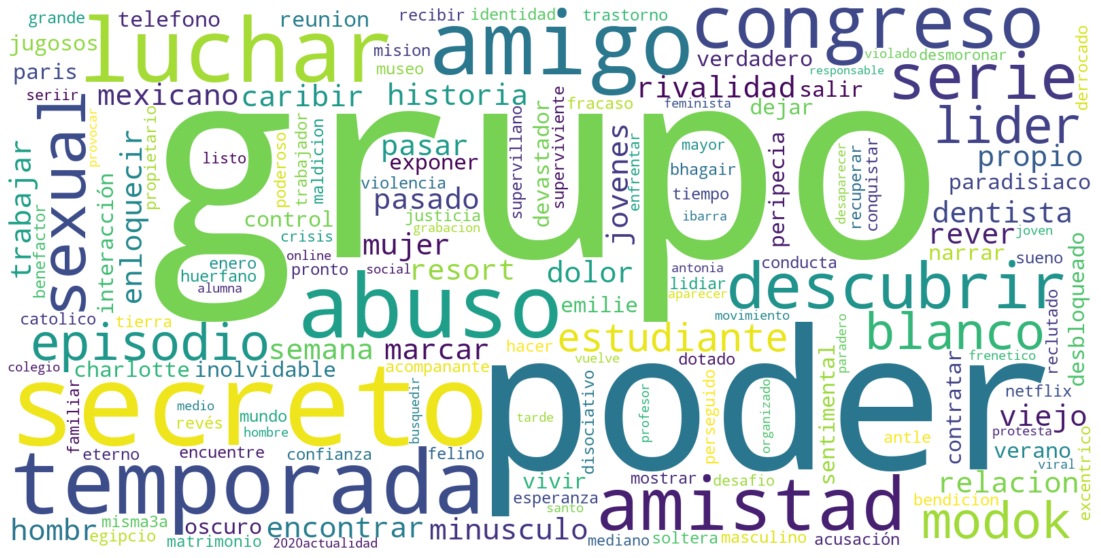

In [26]:
# Cargamos las librerías a utilizar
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#ponemos en un vector las peliculas recomendadas
pelis_rec=pelis[pelis['titulo'].isin(recomendador('Las iguanas'))]

#Limpiamos el texto
text = " ".join(pelis_rec['sinopsis'])
text = sinopsis_cleaning(text)
text=' '.join(text)

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_stopwords, 
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

La nube de palabras confirma la intuición de que el recomendador está sugiriendo series sobre grupos de amigos y la trama contiene secretos, poder y abuso.

## Recomendador basado en metadatos

Para construir el recomendador basado en metadatos seguiremos una estrategia similar a la de la sección previa, sin embargo, cambiaremos los datos que sirven como insumo para generar las recomendaciones.

Seguiremos utilizando la base de datos de películas y series que introdujimos en la sección anterior. El foco lo pondremos sobre los metadatos de estas películas/series, específicamente sobre el género, el reparto y la dirección.

In [27]:
pelis = pd.read_csv('data/pelis_recommend.csv', sep=',')
pelis[['titulo','genero','reparto','direccion']].head()

,titulo,genero,reparto,direccion
0,Chapelwaite,Serie de TV. Drama. Terror. Intriga,"Adrien Brody, Jennifer Ens, Sirena Gulamgaus, ...","Stephen King (Creador), Rachel Leiterman, Mich..."
1,Las iguanas,Serie de TV. Drama | Miniserie de TV. Abusos s...,"Camilo Amores, Silvia Varón, Mario Espitia, Is...",Frank Benitez Peña
2,The Time Traveler's Wife,Serie de TV. Fantástico. Drama | Viajes en el ...,"Rose Leslie, Theo James, Desmin Borges, Natash...","Steven Moffat (Creador), David Nutter"
3,Sluga narodaaka,Serie de TV. Comedia | Sátira. Política,"Vladimir Zelenskiy, Vladyslav Dmytrenko, Boris...","Vladimir Zelenskiy (Creador), Aleksey Kiryushc..."
4,Hacks,Serie de TV. Comedia. Drama | Stand-Up,"Jean Smart, Hannah Einbinder, Rose Abdoo, Haye...","Lucia Aniello (Creador), Paul W. Downs (Creado..."


Podemos ver que potencialmente hay información valiosa, pero es necesario "limpiar" estos datos. En el caso de nombres necesitamos limpiarlos de forma tal que el vectorizador trate a dos individuos con el mismo primer nombre como individuos distintos; por ejemplo, Diego Peretti y Diego Cremonesi. El vectorizador tratará a ambos Diegos como sí fuesen el mismo individuo lo que puede afectar las recomendaciones.

### Preparando los datos

En esta sección limpiaremos los datos de manera levemente diferente a como lo hicimos en la sección anterior para mostrar que hay múltiples caminos y formas de hacer esta tarea, como así también la versatilidad de `Python`. 

Comencemos limpiando el género. Para ello primero remplazaremos las barras verticales pondremos todo en minúsculas y unificaremos términos, por ejemplo "Serie de TV" se volverá *seriedetv*.

In [28]:
#Remplazamos barras verticales por puntos 
pelis['genero']=pelis['genero'].str.replace("|",".",regex=True)
#Creamos una lista de términos delimitados por puntos
pelis['genero']=pelis['genero'].str.split(".")
pelis[['titulo','genero','reparto','direccion']].head()

,titulo,genero,reparto,direccion
0,Chapelwaite,"[Serie de TV, Drama, Terror, Intriga]","Adrien Brody, Jennifer Ens, Sirena Gulamgaus, ...","Stephen King (Creador), Rachel Leiterman, Mich..."
1,Las iguanas,"[Serie de TV, Drama , Miniserie de TV, Abus...","Camilo Amores, Silvia Varón, Mario Espitia, Is...",Frank Benitez Peña
2,The Time Traveler's Wife,"[Serie de TV, Fantástico, Drama , Viajes en...","Rose Leslie, Theo James, Desmin Borges, Natash...","Steven Moffat (Creador), David Nutter"
3,Sluga narodaaka,"[Serie de TV, Comedia , Sátira, Política]","Vladimir Zelenskiy, Vladyslav Dmytrenko, Boris...","Vladimir Zelenskiy (Creador), Aleksey Kiryushc..."
4,Hacks,"[Serie de TV, Comedia, Drama , Stand-Up]","Jean Smart, Hannah Einbinder, Rose Abdoo, Haye...","Lucia Aniello (Creador), Paul W. Downs (Creado..."


Con los géneros en una lista crearemos una función limpiadora que nos permitirá normalizar el texto en español, remover espacios en blanco, y poner todo en minúscula:

In [29]:
# Cargamos la librerías a utilizar para normalizar el texto en español
#import unidecode

#Definimos nuestra función 
def limpiadora(x):
    if isinstance(x, list):
        #para listas
        return [unidecode.unidecode(str.lower(i.replace(" ", ""))) for i in x]
    else:
        #para strings
        if isinstance(x, str):
            return unidecode.unidecode(str.lower(x.replace(" ", "")))
        else:
            return ''

In [30]:
pelis['genero']=pelis['genero'].apply(limpiadora)
#Retenemos sólo los primeros tres generos mencionados
pelis['genero'] =pelis['genero'].apply(lambda x: x[:3])
pelis[['titulo','genero']].head()

,titulo,genero
0,Chapelwaite,"[seriedetv, drama, terror]"
1,Las iguanas,"[seriedetv, drama, miniseriedetv]"
2,The Time Traveler's Wife,"[seriedetv, fantastico, drama]"
3,Sluga narodaaka,"[seriedetv, comedia, satira]"
4,Hacks,"[seriedetv, comedia, drama]"


tenemos entonces "limpia" la columna de género. Procedemos de manera similar con el reparto, pero además en este ejercicio sólo nos quedaremos con los 4 actores principales

In [31]:
#Creamos una lista de actores delimitados por puntos
pelis['reparto']=pelis['reparto'].str.split(",")
#"Limpiamos" los datos del reparto
pelis['reparto']=pelis['reparto'].apply(limpiadora)
#Retenemos sólo los primeros cuatro actores mencionados
pelis['reparto'] =pelis['reparto'].apply(lambda x: x[:4])
pelis[['titulo','genero','reparto','direccion']].head()

,titulo,genero,reparto,direccion
0,Chapelwaite,"[seriedetv, drama, terror]","[adrienbrody, jenniferens, sirenagulamgaus, em...","Stephen King (Creador), Rachel Leiterman, Mich..."
1,Las iguanas,"[seriedetv, drama, miniseriedetv]","[camiloamores, silviavaron, marioespitia, isab...",Frank Benitez Peña
2,The Time Traveler's Wife,"[seriedetv, fantastico, drama]","[roseleslie, theojames, desminborges, natashal...","Steven Moffat (Creador), David Nutter"
3,Sluga narodaaka,"[seriedetv, comedia, satira]","[vladimirzelenskiy, vladyslavdmytrenko, borisa...","Vladimir Zelenskiy (Creador), Aleksey Kiryushc..."
4,Hacks,"[seriedetv, comedia, drama]","[jeansmart, hannaheinbinder, roseabdoo, hayesb...","Lucia Aniello (Creador), Paul W. Downs (Creado..."


Finalmente nos queda la función de dirección. Notemos que aparece entre paréntesis la palabra creador al lado del director que también fue el creador. Utilizaremos entonces primero expresiones regulares para quitar esta palabra con los paréntesis y luego procederemos de manera similar a como lo hicimos anteriormente. Respecto al director solamente nos quedaremos con el individuo que aparece primero.

In [32]:
#Removemos "(Creador)"
pelis['direccion']=pelis['direccion'].str.replace("\\(Creador\\)","",regex=True)
#Creamos una lista de actores delimitados por puntos
pelis['direccion']=pelis['direccion'].str.split(",")
#"Limpiamos" los datos de direccion
pelis['direccion']=pelis['direccion'].apply(limpiadora)
#Retenemos sólo el primer director
pelis['direccion'] =pelis['direccion'].apply(lambda x: x[:1])
pelis[['titulo','direccion']].head()

,titulo,direccion
0,Chapelwaite,[stephenking]
1,Las iguanas,[frankbenitezpena]
2,The Time Traveler's Wife,[stevenmoffat]
3,Sluga narodaaka,[vladimirzelenskiy]
4,Hacks,[luciaaniello]


Con estos datos entonces estamos en condiciones de generar una columna que combine toda esta información. Para ello crearemos una función que concatene estos caracteres:

In [33]:
def crear_metadatos(x):
        return ' '.join(x['genero']) + ' ' + ' '.join(x['reparto']) + ' ' + ''.join(x['direccion'] )

Aplicamos esta función a todas las filas creando la columna `metadato`:

In [34]:
pelis['metadatos'] = pelis.apply(crear_metadatos, axis=1)

Veamos como luce la primer entrada:

In [35]:
pelis.iloc[0]['metadatos']

'seriedetv drama terror adrienbrody jenniferens sirenagulamgaus emilyhampshire stephenking'

Tenemos entonces un vector que combina toda la información de las columnas: Chapelwaite es una serie de tv, drama, terror e intriga con las actuaciones de Adrien Brody, Jennifer Ens, Sirena Gulamgaus y Emily Hampshire, dirigida por Stephen King.

### Generando recomendaciones

Procederemos entonces de manera similar a la sección anterior. A diferencia de la sección previa utilizaremos `CountVectorizer` y no `TF-IDFVectorizer`. Esto se debe a que `TF-IDFVectorizer` penaliza a aquellos actores y directores que aparecen más frecuentemente, y esto potencialmente sesgaría las recomendaciones. Sin embargo, te invito a que pruebes como cambiarían las recomendaciones utilizando el `TF-IDFVectorizer`.

Comenzamos importando  el objeto [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) de [scikit](https://scikit-learn.org/stable/) que nos va a permitir crear la matriz con los documentos vectorizados, y utilizamos las *stopwords* definidas anteriormente

In [36]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Definimos un objeto CountVectorizer y creamos los vectores
count = CountVectorizer(stop_words=set(lista_stopwords))
count_matrix = count.fit_transform(pelis['metadatos'])
count_matrix

<1321x4745 sparse matrix of type '<class 'numpy.int64'>'
	with 9272 stored elements in Compressed Sparse Row format>

Generamos entonces una matriz poco densa de dimensión 1321 x 4849. Necesitamos entonces ahora calcular la similitud de coseno entre estos vectores. Para ello usamos la función [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

In [37]:
#Importamos la función 
from sklearn.metrics.pairwise import cosine_similarity

#Calculamos la matriz de similitud de coseno
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

cosine_sim2

array([[1.        , 0.25      , 0.25      , ..., 0.        , 0.125     ,
        0.        ],
       [0.25      , 1.        , 0.25      , ..., 0.        , 0.125     ,
        0.        ],
       [0.25      , 0.25      , 1.        , ..., 0.13363062, 0.125     ,
        0.        ],
       ...,
       [0.        , 0.        , 0.13363062, ..., 1.        , 0.        ,
        0.12598816],
       [0.125     , 0.125     , 0.125     , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.12598816, 0.        ,
        1.        ]])

Vemos entonces que la diagonal principal tendrá 1 ya que la similitud de cada película/serie consigo misma es uno.

Con esta información el paso final es remplazar en la función que creamos en la sección anterior la matriz de similitud de coseno.

In [38]:
recom=recomendador('Las iguanas', cosine_sim=cosine_sim2, df=pelis)
recom

129                                Scenes from a Marriage
228                                                Patria
229                                     We Are Who We Are
230                                         The Third Day
639                                 The Unlikely Murderer
779                                             Oussekine
827                                          Mrs. America
1253    Isabel: La historia íntima de la escritora Isa...
274                                               Neumatt
1210                               Nine Perfect Strangers
Name: titulo, dtype: object

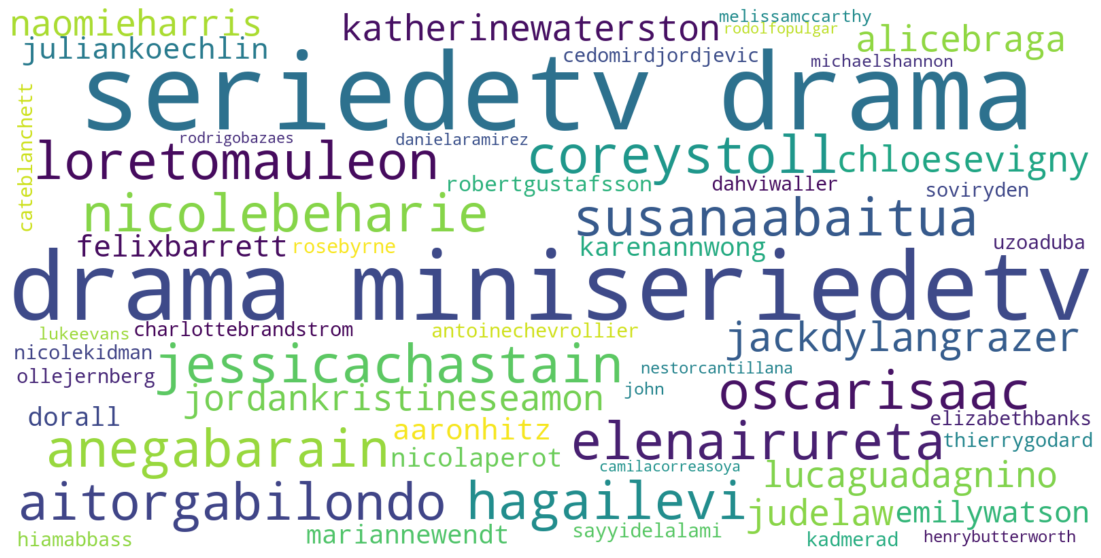

In [39]:
# Cargamos las librerías a utilizar
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#creamoes un subset de las películas/series recomendadas
pelis_rec=pelis[pelis['titulo'].isin(recom)]

# Armamos la nube de palabras
text = " ".join(pelis_rec['metadatos'])
wordcloud = WordCloud(width = 1600, height = 800, stopwords = set(lista_stopwords), 
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Notemos que la recomendaciones son claramente distintas y se enfocaron en dramas que son series de televisión, y los actores aparecen más representados.

## Consideraciones finales

Los recomendadores basados en contenido que creamos en este *cuaderno*, por supuesto, no se acercan a los poderosos modelos utilizados en la industria. Todavía existe mucho margen de mejora. Entre las mejoras que podemos pensar están:

- Experimentar con la cantidad de géneros, actores y directores.
- Crear subgéneros a partir de géneros, por ejemplo, comedia es el género y el comedia-negra el subgénero.
- Dar más peso a ciertas características. Por ejemplo, podríamos darle más importancia al director repitiendo las veces que aparece en los metadatos.
- Considerando otra información como ser miembros del equipo, premios, etc.
- Combinando información de la trama con los metadatos y popularidad

Te invito a que pruebes estas alternativas.

## Referencias

- Banik, R. (2018). Hands-on recommendation systems with Python: start building powerful and personalized, recommendation engines with Python. Packt Publishing Ltd.

- Fradejas Rueda, J. M. (2020). Cuentapalabras. Estilometrıa y análisis de texto con R para filólogos.

- Google developers. (n.d.). Recommendation systems. Google. Consultado en Abril 3, 2022, de https://developers.google.com/machine-learning/recommendation/overview 

- Patel, A. A. (2019). Hands-on unsupervised learning using Python: how to build applied machine learning solutions from unlabeled data. O'Reilly Media.
